# Problem 1: Sparse Encoding for Image Denoising (30pts)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm #
import random


# Hyperparameters
input_dim = 28 * 28  # MNIST images are 28x28
hidden_dim = int(1.5 * input_dim)  # 1.5 times the input dimension i.e 42x42
batch_size = 128
learning_rate = 1e-3
num_epochs = 20
sigma = 0.5  # Standard deviation for Gaussian noise
lambda_l1 = 1e-3  # Regularization parameter for L1 loss

# Device configuration
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'Using device: {device}')

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform,
                              download=True)

# Data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

# Define the Auto-Encoder model
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(AutoEncoder, self).__init__()
        # Encoder: Linear layer followed by ReLU
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        # Decoder: Linear layer
        self.decoder = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, x):
        h = self.encoder(x)
        out = self.decoder(h)
        return out, h

# Initialize the model, loss function, and optimizer
model = AutoEncoder(input_dim, hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
model.train()
for epoch in tqdm(range(num_epochs), desc="Epochs"):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(tqdm(train_loader, desc="Batches", leave=False)):
        # Flatten the images
        data = data.view(-1, input_dim).to(device)
        # Add Gaussian noise
        noise = torch.randn_like(data) * sigma
        noisy_data = data + noise
        noisy_data = torch.clamp(noisy_data, 0., 1.)  # Ensure values are between 0 and 1

        # Forward pass
        outputs, h = model(noisy_data)
        mse_loss = criterion(outputs, data)
        l1_loss = torch.mean(torch.abs(h))
        loss = mse_loss + lambda_l1 * l1_loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

# Switch to evaluation mode
model.eval()

# Function to add Gaussian noise
def add_noise(x, sigma):
    noise = torch.randn_like(x) * sigma
    noisy = x + noise
    noisy = torch.clamp(noisy, 0., 1.)
    return noisy

Using device: mps


Epochs:   5%|▌         | 1/20 [00:03<00:57,  3.01s/it]

Epoch [1/20], Loss: 0.0271


Epochs:  10%|█         | 2/20 [00:05<00:51,  2.88s/it]

Epoch [2/20], Loss: 0.0190


Epochs:  15%|█▌        | 3/20 [00:08<00:49,  2.92s/it]

Epoch [3/20], Loss: 0.0177


Epochs:  20%|██        | 4/20 [00:11<00:48,  3.02s/it]

Epoch [4/20], Loss: 0.0169


Epochs:  25%|██▌       | 5/20 [00:15<00:47,  3.16s/it]

Epoch [5/20], Loss: 0.0164


Epochs:  30%|███       | 6/20 [00:18<00:42,  3.02s/it]

Epoch [6/20], Loss: 0.0160


Epochs:  35%|███▌      | 7/20 [00:20<00:37,  2.91s/it]

Epoch [7/20], Loss: 0.0157


Epochs:  40%|████      | 8/20 [00:23<00:34,  2.85s/it]

Epoch [8/20], Loss: 0.0156


Epochs:  45%|████▌     | 9/20 [00:26<00:30,  2.77s/it]

Epoch [9/20], Loss: 0.0154


Epochs:  50%|█████     | 10/20 [00:28<00:27,  2.77s/it]

Epoch [10/20], Loss: 0.0153


Epochs:  55%|█████▌    | 11/20 [00:31<00:24,  2.72s/it]

Epoch [11/20], Loss: 0.0152


Epochs:  60%|██████    | 12/20 [00:34<00:21,  2.68s/it]

Epoch [12/20], Loss: 0.0151


Epochs:  65%|██████▌   | 13/20 [00:36<00:18,  2.67s/it]

Epoch [13/20], Loss: 0.0150


Epochs:  70%|███████   | 14/20 [00:39<00:15,  2.65s/it]

Epoch [14/20], Loss: 0.0149


Epochs:  75%|███████▌  | 15/20 [00:42<00:13,  2.69s/it]

Epoch [15/20], Loss: 0.0149


Epochs:  80%|████████  | 16/20 [00:45<00:11,  2.79s/it]

Epoch [16/20], Loss: 0.0148


Epochs:  85%|████████▌ | 17/20 [00:47<00:08,  2.78s/it]

Epoch [17/20], Loss: 0.0148


Epochs:  90%|█████████ | 18/20 [00:50<00:05,  2.76s/it]

Epoch [18/20], Loss: 0.0148


Epochs:  95%|█████████▌| 19/20 [00:53<00:02,  2.74s/it]

Epoch [19/20], Loss: 0.0147


Epochs: 100%|██████████| 20/20 [00:55<00:00,  2.80s/it]

Epoch [20/20], Loss: 0.0147


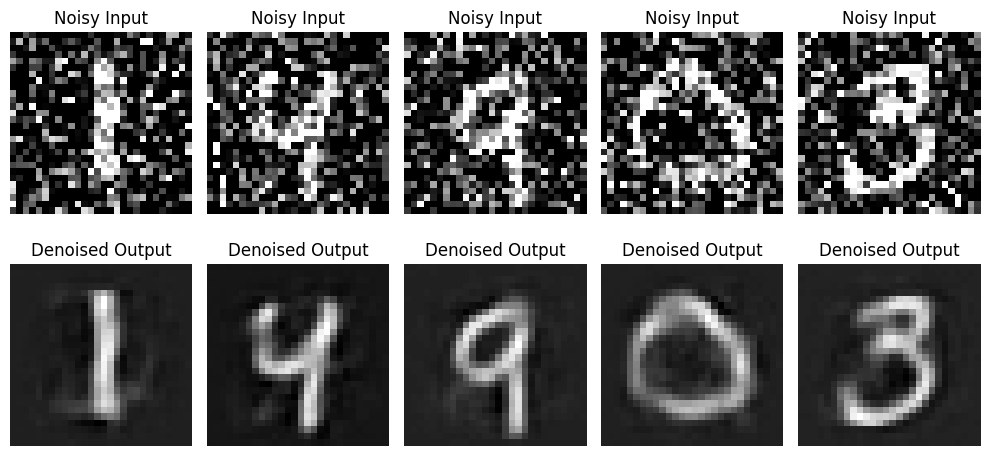

In [28]:
# 1. Plot 5 input-output pairs using the test set

# Get a batch from the test loader
test_iter = iter(test_loader)
test_images, _ = next(test_iter)
test_images = test_images.view(-1, input_dim).to(device)

# Select 5 random samples
indices = random.sample(range(test_images.size(0)), 5)
sample_images = test_images[indices]
noisy_samples = add_noise(sample_images, sigma)

# Pass through the auto-encoder
with torch.no_grad():
    reconstructed, _ = model(noisy_samples)

# Move to CPU and reshape for plotting
sample_images = sample_images.cpu().numpy()
noisy_samples = noisy_samples.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plotting
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i in range(5):
    # Noisy input
    axes[0, i].imshow(noisy_samples[i].reshape(28, 28), cmap='gray')
    axes[0, i].set_title('Noisy Input')
    axes[0, i].axis('off')
    
    # Denoised output
    axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap='gray')
    axes[1, i].set_title('Denoised Output')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

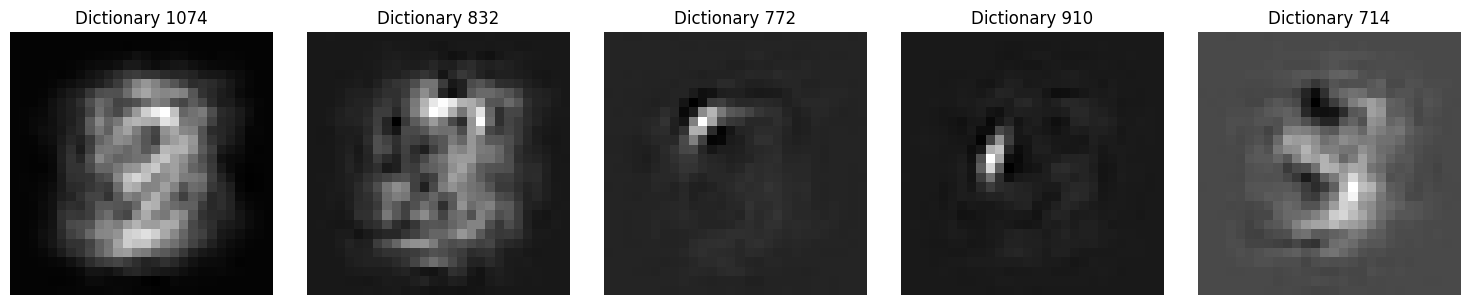

In [29]:
# 2. Plot the top 5 dictionary vectors in D with the largest corresponding |h_i|
# First, gather all h from the test set
all_h = []
with torch.no_grad():
    for data, _ in test_loader:
        data = data.view(-1, input_dim).to(device)
        noisy_data = add_noise(data, sigma)
        _, h = model(noisy_data)
        all_h.append(torch.abs(h))
# Concatenate all h
all_h = torch.cat(all_h, dim=0)  # Shape: [num_test_samples, hidden_dim]

# Compute average |h_i| across all test samples
avg_h = torch.mean(all_h, dim=0)  # Shape: [hidden_dim]

# Get the indices of top 5 h_i
top5_indices = torch.topk(avg_h, 5).indices.cpu().numpy()

# Get the corresponding dictionary vectors from D (decoder weights)
# Decoder weight shape: [input_dim, hidden_dim]
D = model.decoder.weight.data.cpu().numpy().T  # Shape: [hidden_dim, input_dim]

top5_D = D[top5_indices]  # Shape: [5, input_dim]

# Plot the top 5 dictionary vectors
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(top5_D[i].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Dictionary {top5_indices[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Probem 2: Modified Probablistic PCA on MNIST (30pts)

Using device: cpu

=== Training PPCA with latent dimension: 2 ===


Epoch [1/50] Average Loss per Sample: 11.2163


Epoch [2/50] Average Loss per Sample: -107.1948


Epoch [3/50] Average Loss per Sample: -198.7364


Epoch [4/50] Average Loss per Sample: -281.6496


Epoch [5/50] Average Loss per Sample: -357.2223


Epoch [6/50] Average Loss per Sample: -426.7630


Epoch [7/50] Average Loss per Sample: -491.0559


Epoch [8/50] Average Loss per Sample: -550.5440


Epoch [9/50] Average Loss per Sample: -605.5303


Epoch [10/50] Average Loss per Sample: -656.1490


Epoch [11/50] Average Loss per Sample: -702.6625


Epoch [12/50] Average Loss per Sample: -745.4035


Epoch [13/50] Average Loss per Sample: -784.6820


Epoch [14/50] Average Loss per Sample: -820.8361


Epoch [15/50] Average Loss per Sample: -854.2217


Epoch [16/50] Average Loss per Sample: -885.0680


Epoch [17/50] Average Loss per Sample: -913.4991


Epoch [18/50] Average Loss per Sample: -939.8108


Epoch [19/50] Average Loss per Sample: -964.0186


Epoch [20/50] Average Loss per Sample: -986.3183


Epoch [21/50] Average Loss per Sample: -1006.4638


Epoch [22/50] Average Loss per Sample: -1024.3908


Epoch [23/50] Average Loss per Sample: -1040.0502


Epoch [24/50] Average Loss per Sample: -1053.2734


Epoch [25/50] Average Loss per Sample: -1064.2947


Epoch [26/50] Average Loss per Sample: -1073.2371


Epoch [27/50] Average Loss per Sample: -1080.3870


Epoch [28/50] Average Loss per Sample: -1086.0165


Epoch [29/50] Average Loss per Sample: -1090.4249


Epoch [30/50] Average Loss per Sample: -1094.0735


Epoch [31/50] Average Loss per Sample: -1096.8867


Epoch [32/50] Average Loss per Sample: -1099.1748


Epoch [33/50] Average Loss per Sample: -1101.1017


Epoch [34/50] Average Loss per Sample: -1102.6805


Epoch [35/50] Average Loss per Sample: -1103.9730


Epoch [36/50] Average Loss per Sample: -1105.0480


Epoch [37/50] Average Loss per Sample: -1105.9976


Epoch [38/50] Average Loss per Sample: -1106.7656


Epoch [39/50] Average Loss per Sample: -1107.5043


Epoch [40/50] Average Loss per Sample: -1108.0649


Epoch [41/50] Average Loss per Sample: -1108.6432


Epoch [42/50] Average Loss per Sample: -1109.0337


Epoch [43/50] Average Loss per Sample: -1109.4590


Epoch [44/50] Average Loss per Sample: -1109.8022


Epoch [45/50] Average Loss per Sample: -1110.0967


Epoch [46/50] Average Loss per Sample: -1110.4428


Epoch [47/50] Average Loss per Sample: -1110.6345


Epoch [48/50] Average Loss per Sample: -1110.9337


Epoch [49/50] Average Loss per Sample: -1111.0985


Epoch [50/50] Average Loss per Sample: -1111.3532


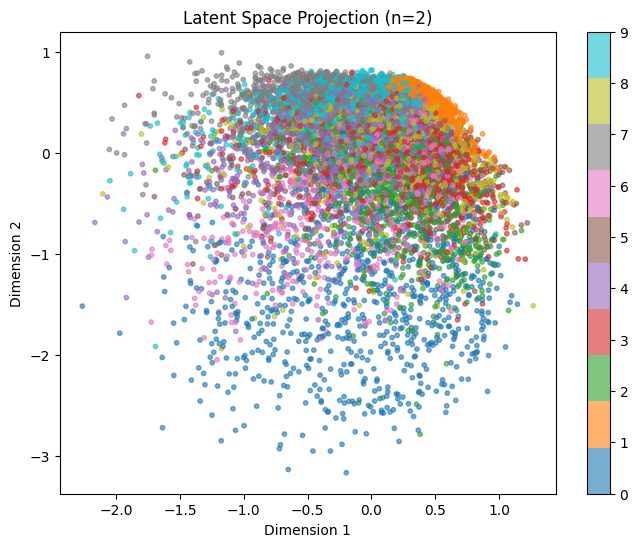

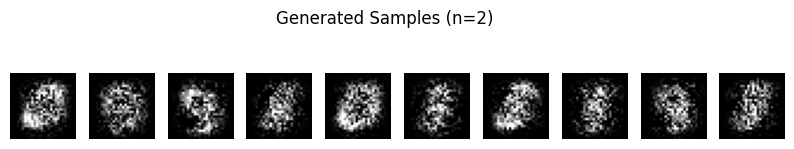


=== Training PPCA with latent dimension: 4 ===


Epoch [1/50] Average Loss per Sample: -13.3081


Epoch [2/50] Average Loss per Sample: -134.6653


Epoch [3/50] Average Loss per Sample: -225.4179


Epoch [4/50] Average Loss per Sample: -307.4395


Epoch [5/50] Average Loss per Sample: -382.8016


Epoch [6/50] Average Loss per Sample: -452.4543


Epoch [7/50] Average Loss per Sample: -516.9630


Epoch [8/50] Average Loss per Sample: -576.6687


Epoch [9/50] Average Loss per Sample: -631.6972


Epoch [10/50] Average Loss per Sample: -682.3320


Epoch [11/50] Average Loss per Sample: -728.8323


Epoch [12/50] Average Loss per Sample: -771.5267


Epoch [13/50] Average Loss per Sample: -810.7806


Epoch [14/50] Average Loss per Sample: -846.9446


Epoch [15/50] Average Loss per Sample: -880.2190


Epoch [16/50] Average Loss per Sample: -910.9762


Epoch [17/50] Average Loss per Sample: -939.3606


Epoch [18/50] Average Loss per Sample: -965.5228


Epoch [19/50] Average Loss per Sample: -989.7041


Epoch [20/50] Average Loss per Sample: -1011.8846


Epoch [21/50] Average Loss per Sample: -1032.0898


Epoch [22/50] Average Loss per Sample: -1049.9420


Epoch [23/50] Average Loss per Sample: -1065.5505


Epoch [24/50] Average Loss per Sample: -1078.8110


Epoch [25/50] Average Loss per Sample: -1089.6671


Epoch [26/50] Average Loss per Sample: -1098.5926


Epoch [27/50] Average Loss per Sample: -1105.8197


Epoch [28/50] Average Loss per Sample: -1111.3427


Epoch [29/50] Average Loss per Sample: -1115.8653


Epoch [30/50] Average Loss per Sample: -1119.3832


Epoch [31/50] Average Loss per Sample: -1122.2190


Epoch [32/50] Average Loss per Sample: -1124.6337


Epoch [33/50] Average Loss per Sample: -1126.3589


Epoch [34/50] Average Loss per Sample: -1127.9378


Epoch [35/50] Average Loss per Sample: -1129.1789


Epoch [36/50] Average Loss per Sample: -1130.3607


Epoch [37/50] Average Loss per Sample: -1131.2447


Epoch [38/50] Average Loss per Sample: -1132.0988


Epoch [39/50] Average Loss per Sample: -1132.7053


Epoch [40/50] Average Loss per Sample: -1133.2799


Epoch [41/50] Average Loss per Sample: -1133.7666


Epoch [42/50] Average Loss per Sample: -1134.2486


Epoch [43/50] Average Loss per Sample: -1134.5598


Epoch [44/50] Average Loss per Sample: -1135.0463


Epoch [45/50] Average Loss per Sample: -1135.2916


Epoch [46/50] Average Loss per Sample: -1135.5794


Epoch [47/50] Average Loss per Sample: -1135.8732


Epoch [48/50] Average Loss per Sample: -1136.0115


Epoch [49/50] Average Loss per Sample: -1136.3576


Epoch [50/50] Average Loss per Sample: -1136.3394


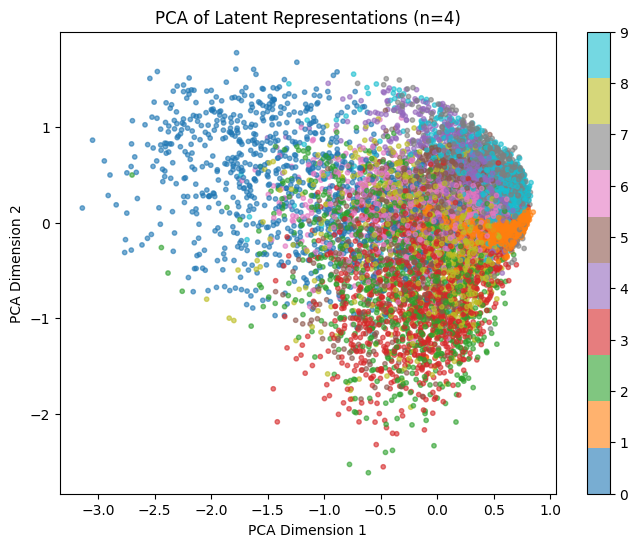

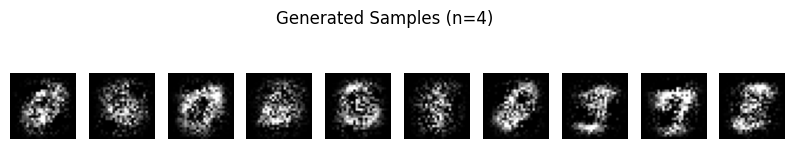


=== Training PPCA with latent dimension: 8 ===


Epoch [1/50] Average Loss per Sample: -44.1910


Epoch [2/50] Average Loss per Sample: -167.2612


Epoch [3/50] Average Loss per Sample: -258.0484


Epoch [4/50] Average Loss per Sample: -340.4325


Epoch [5/50] Average Loss per Sample: -416.2585


Epoch [6/50] Average Loss per Sample: -486.2444


Epoch [7/50] Average Loss per Sample: -550.9342


Epoch [8/50] Average Loss per Sample: -610.7127


Epoch [9/50] Average Loss per Sample: -665.8593


Epoch [10/50] Average Loss per Sample: -716.4813


Epoch [11/50] Average Loss per Sample: -762.9945


Epoch [12/50] Average Loss per Sample: -805.6592


Epoch [13/50] Average Loss per Sample: -844.7885


Epoch [14/50] Average Loss per Sample: -880.8565


Epoch [15/50] Average Loss per Sample: -914.0737


Epoch [16/50] Average Loss per Sample: -944.8270


Epoch [17/50] Average Loss per Sample: -973.0835


Epoch [18/50] Average Loss per Sample: -999.1593


Epoch [19/50] Average Loss per Sample: -1023.3107


Epoch [20/50] Average Loss per Sample: -1045.2614


Epoch [21/50] Average Loss per Sample: -1065.2629


Epoch [22/50] Average Loss per Sample: -1082.8640


Epoch [23/50] Average Loss per Sample: -1098.3618


Epoch [24/50] Average Loss per Sample: -1111.4233


Epoch [25/50] Average Loss per Sample: -1122.3575


Epoch [26/50] Average Loss per Sample: -1131.1113


Epoch [27/50] Average Loss per Sample: -1138.3371


Epoch [28/50] Average Loss per Sample: -1143.8317


Epoch [29/50] Average Loss per Sample: -1148.1199


Epoch [30/50] Average Loss per Sample: -1151.6931


Epoch [31/50] Average Loss per Sample: -1154.4801


Epoch [32/50] Average Loss per Sample: -1156.8619


Epoch [33/50] Average Loss per Sample: -1158.6488


Epoch [34/50] Average Loss per Sample: -1159.7323


Epoch [35/50] Average Loss per Sample: -1161.4352


Epoch [36/50] Average Loss per Sample: -1162.5006


Epoch [37/50] Average Loss per Sample: -1163.4584


Epoch [38/50] Average Loss per Sample: -1164.2261


Epoch [39/50] Average Loss per Sample: -1164.8724


Epoch [40/50] Average Loss per Sample: -1165.2651


Epoch [41/50] Average Loss per Sample: -1165.8178


Epoch [42/50] Average Loss per Sample: -1166.5300


Epoch [43/50] Average Loss per Sample: -1166.4532


Epoch [44/50] Average Loss per Sample: -1167.0244


Epoch [45/50] Average Loss per Sample: -1167.1960


Epoch [46/50] Average Loss per Sample: -1167.7051


Epoch [47/50] Average Loss per Sample: -1167.8173


Epoch [48/50] Average Loss per Sample: -1168.0167


Epoch [49/50] Average Loss per Sample: -1168.1190


Epoch [50/50] Average Loss per Sample: -1168.2895


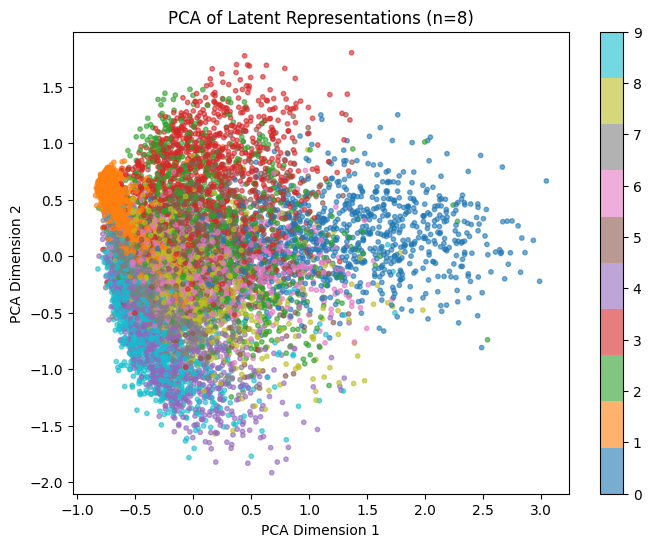

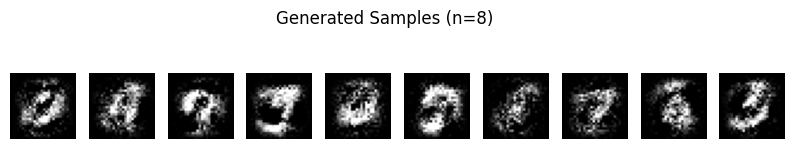


=== Training PPCA with latent dimension: 32 ===


Epoch [1/50] Average Loss per Sample: -104.8718


Epoch [2/50] Average Loss per Sample: -248.8199


Epoch [3/50] Average Loss per Sample: -350.2296


Epoch [4/50] Average Loss per Sample: -437.0311


Epoch [5/50] Average Loss per Sample: -515.1785


Epoch [6/50] Average Loss per Sample: -586.6623


Epoch [7/50] Average Loss per Sample: -652.3781


Epoch [8/50] Average Loss per Sample: -712.5993


Epoch [9/50] Average Loss per Sample: -767.8669


Epoch [10/50] Average Loss per Sample: -818.3458


Epoch [11/50] Average Loss per Sample: -864.5993


Epoch [12/50] Average Loss per Sample: -906.7918


Epoch [13/50] Average Loss per Sample: -945.4471


Epoch [14/50] Average Loss per Sample: -980.9687


Epoch [15/50] Average Loss per Sample: -1013.3883


Epoch [16/50] Average Loss per Sample: -1043.0672


Epoch [17/50] Average Loss per Sample: -1070.4661


Epoch [18/50] Average Loss per Sample: -1094.8003


Epoch [19/50] Average Loss per Sample: -1118.0208


Epoch [20/50] Average Loss per Sample: -1138.1415


Epoch [21/50] Average Loss per Sample: -1155.9251


Epoch [22/50] Average Loss per Sample: -1171.5368


Epoch [23/50] Average Loss per Sample: -1186.0863


Epoch [24/50] Average Loss per Sample: -1197.7209


Epoch [25/50] Average Loss per Sample: -1207.2244


Epoch [26/50] Average Loss per Sample: -1215.4038


Epoch [27/50] Average Loss per Sample: -1219.0153


Epoch [28/50] Average Loss per Sample: -1226.2433


Epoch [29/50] Average Loss per Sample: -1228.7861


Epoch [30/50] Average Loss per Sample: -1231.9075


Epoch [31/50] Average Loss per Sample: -1236.5542


Epoch [32/50] Average Loss per Sample: -1239.6303


Epoch [33/50] Average Loss per Sample: -1239.4663


Epoch [34/50] Average Loss per Sample: -1241.5222


Epoch [35/50] Average Loss per Sample: -1241.1257


Epoch [36/50] Average Loss per Sample: -1242.8108


Epoch [37/50] Average Loss per Sample: -1243.7888


Epoch [38/50] Average Loss per Sample: -1244.0263


Epoch [39/50] Average Loss per Sample: -1243.2790


Epoch [40/50] Average Loss per Sample: -1243.6491


Epoch [41/50] Average Loss per Sample: -1242.6528


Epoch [42/50] Average Loss per Sample: -1243.6610


Epoch [43/50] Average Loss per Sample: -1246.0986


Epoch [44/50] Average Loss per Sample: -1245.3973


Epoch [45/50] Average Loss per Sample: -1245.0243


Epoch [46/50] Average Loss per Sample: -1243.7977


Epoch [47/50] Average Loss per Sample: -1244.2970


Epoch [48/50] Average Loss per Sample: -1244.8160


Epoch [49/50] Average Loss per Sample: -1244.6454


Epoch [50/50] Average Loss per Sample: -1242.8962


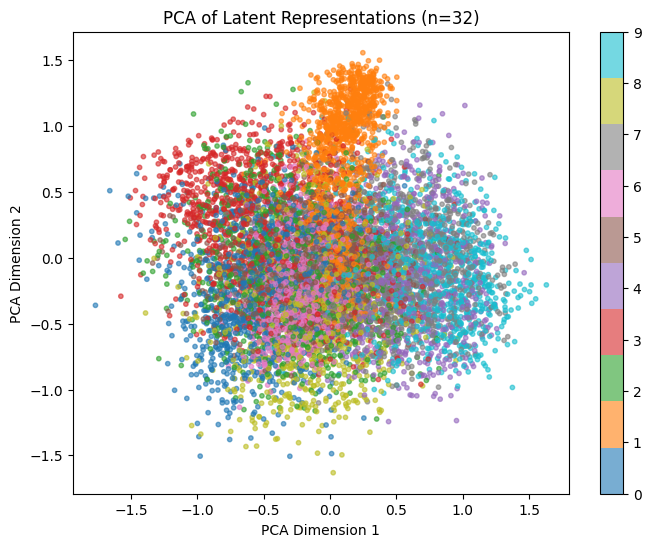

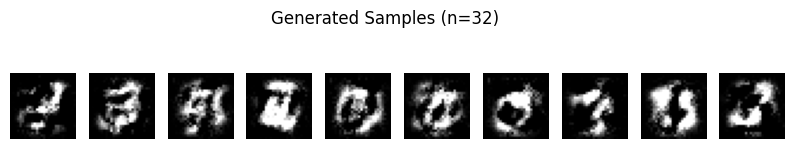

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

# Define the PPCA model
class PPCA(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(PPCA, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        # Initialize W, mu, and log_sigma as learnable parameters
        self.W = nn.Parameter(torch.randn(input_dim, latent_dim) * 0.01)
        self.mu = nn.Parameter(torch.zeros(input_dim))
        # Initialize log_sigma with small positive values to avoid numerical issues
        self.log_sigma = nn.Parameter(torch.log(torch.ones(input_dim) * 0.1))

    def forward(self, x):
        r"""
        Computes the negative log-likelihood for PPCA:
        \[
        \ell (W, \mu, \sigma^2) = \sum_{i=1}^N \left( \frac{1}{2} \left( D \log(2\pi) + \log |C| + (x^{(i)} - \mu)^T C^{-1} (x^{(i)} - \mu) \right) \right)
        \]
        where \( C = W W^T + \text{diag}(\sigma^2) \).
        """
        batch_size = x.size(0)
        # Compute sigma^2 = exp(log_sigma) to ensure positivity
        sigma2 = torch.exp(self.log_sigma)  # Shape: [D]
        # Construct covariance matrix C = W W^T + diag(sigma^2)
        C = self.W @ self.W.t() + torch.diag(sigma2)  # Shape: [D, D]

        # Center the data
        x_centered = x - self.mu  # Shape: [batch_size, D]

        # Cholesky decomposition for numerical stability
        epsilon = 1e-6
        try:
            L = torch.linalg.cholesky(C + epsilon * torch.eye(self.input_dim, device=x.device))
        except RuntimeError as e:
            # If Cholesky fails, increase epsilon
            epsilon *= 10
            L = torch.linalg.cholesky(C + epsilon * torch.eye(self.input_dim, device=x.device))

        # Compute log determinant: log|C| = 2 * sum(log(diag(L)))
        log_det_C = 2.0 * torch.sum(torch.log(torch.diagonal(L)))

        # Solve L y = (x - mu).T
        y = torch.linalg.solve_triangular(L, x_centered.t(), upper=False)
        # Compute quadratic term: sum over batch of (y^T y)
        quad_form = torch.sum(y ** 2)

        # Compute the loss
        loss = 0.5 * batch_size * (self.input_dim * torch.log(torch.tensor(2.0 * np.pi)) + log_det_C) + 0.5 * quad_form

        return loss

# Define the training function
def train_ppca(latent_dim, train_loader, device, num_epochs=50, learning_rate=1e-3):
    input_dim = 28 * 28  # MNIST images are 28x28
    model = PPCA(input_dim=input_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False) as tepoch:
            for data, _ in tepoch:
                data = data.view(-1, input_dim).to(device)  # Flatten the images
                optimizer.zero_grad()
                loss = model(data)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        # Compute average loss per sample
        avg_epoch_loss = epoch_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss per Sample: {avg_epoch_loss:.4f}")
    return model

# Visualization function remains the same
def visualize_latent_space(model, test_loader, device, latent_dim, n_components=2):
    """
    Projects the test set into the latent space and visualizes it.
    For n_components=2, creates a 2D scatter plot.
    For higher dimensions, applies PCA for visualization.
    """
    model.eval()
    latent_representations = []
    labels_list = []
    with torch.no_grad():
        sigma2 = torch.exp(model.log_sigma)  # Shape: [D]
        C = model.W @ model.W.t() + torch.diag(sigma2)
        epsilon = 1e-6
        try:
            L = torch.linalg.cholesky(C + epsilon * torch.eye(model.input_dim, device=device))
        except RuntimeError as e:
            epsilon *= 10
            L = torch.linalg.cholesky(C + epsilon * torch.eye(model.input_dim, device=device))

        # Compute C^{-1} W
        temp = torch.linalg.solve_triangular(L, model.W, upper=False)
        C_inv_W = torch.linalg.solve_triangular(L.t(), temp, upper=True)  # Shape: [D, n]

        for data, labels in test_loader:
            data = data.view(-1, model.input_dim).to(device)
            x_centered = data - model.mu  # Shape: [batch_size, D]
            # Compute E[z | x] = (W^T C^{-1}) (x - mu)
            temp = torch.linalg.solve_triangular(L, x_centered.t(), upper=False)
            C_inv_x_mu = torch.linalg.solve_triangular(L.t(), temp, upper=True)
            Ez = model.W.t() @ C_inv_x_mu  # Shape: [n, batch_size]
            latent_z = Ez.t()
            latent_representations.append(latent_z.cpu())
            labels_list.append(labels)

    latent_representations = torch.cat(latent_representations, dim=0).numpy()
    labels_list = torch.cat(labels_list, dim=0).numpy()

    if latent_dim == 2:
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(latent_representations[:,0], latent_representations[:,1], c=labels_list, cmap='tab10', alpha=0.6, s=10)
        plt.colorbar(scatter, ticks=range(10))
        plt.title(f"Latent Space Projection (n={latent_dim})")
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.show()
    else:
        # For higher dimensions, reduce to 2D using PCA for visualization
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(latent_representations)
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels_list, cmap='tab10', alpha=0.6, s=10)
        plt.colorbar(scatter, ticks=range(10))
        plt.title(f"PCA of Latent Representations (n={latent_dim})")
        plt.xlabel("PCA Dimension 1")
        plt.ylabel("PCA Dimension 2")
        plt.show()

def generate_samples(model, device, latent_dim, num_samples=10):
    """
    Generates new samples by sampling z ~ N(0, I) and passing through the PPCA model.
    """
    model.eval()
    with torch.no_grad():
        # Sample z from standard normal
        z = torch.randn(num_samples, latent_dim).to(device)  # Shape: [num_samples, n]
        # Compute x_mean = W z^T + mu
        x_mean = model.W @ z.t() + model.mu.unsqueeze(1)  # Shape: [D, num_samples]
        # Compute sigma^2 = exp(log_sigma)
        sigma2 = torch.exp(model.log_sigma).unsqueeze(1)  # Shape: [D, 1]
        # Sample epsilon ~ N(0, sigma^2)
        epsilon = torch.randn_like(x_mean) * torch.sqrt(sigma2)  # Shape: [D, num_samples]
        # Generate samples
        x_generated = x_mean + epsilon
        x_generated = x_generated.t().cpu().numpy()
        # Clip values to [0,1]
        x_generated = np.clip(x_generated, 0., 1.)

    # Plot the generated samples
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples, 2))
    for i in range(num_samples):
        axes[i].imshow(x_generated[i].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f"Generated Samples (n={latent_dim})")
    plt.show()

# Rest of your training code
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               transform=transform,
                               download=True)
test_dataset = datasets.MNIST(root='./data',
                              train=False,
                              transform=transform,
                              download=True)
batch_size = 128
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

# Define latent dimensions to experiment with
latent_dims = [2, 4, 8, 32]

# Iterate over different latent dimensions
for latent_dim in latent_dims:
    print(f"\n=== Training PPCA with latent dimension: {latent_dim} ===")
    model = train_ppca(latent_dim=latent_dim,
                      train_loader=train_loader,
                      device=device,
                      num_epochs=50,
                      learning_rate=1e-3)

    # Visualize the latent space
    visualize_latent_space(model, test_loader, device, latent_dim)

    # Generate new samples
    generate_samples(model, device, latent_dim, num_samples=10)